# Invisible cloak
1. take a screenshot of the background and the cloak
2. pick HSV values that match the cloak color 
3. apply those HSV values as thresholding
4. erosion and dilation (or closing) for pre-processing before finding contours
5. find the largest contour
6. use the rectangle of the contour as a mask to replace the region of the image with the background


In [2]:
import cv2
import math
import time
import threading
import numpy as np
import random as rng
from matplotlib import pyplot as plt
from ipywidgets import interact,interactive
import ipywidgets as widgets
from IPython.display import display, HTML,clear_output
import IPython.display
import random as rng

In [3]:
def plot_img(img,title):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(img)
    plt.show()
def cap_screen(fname):
    cameraNo = 0
    inputStream = cv2.VideoCapture(cameraNo) 
    for i in range(4):
        print(str(i)+"!")
        time.sleep(1)
    print("Action!")
    _, videoFrameBGR = inputStream.read()
    inputStream.release()
    plot_img(cv2.cvtColor(videoFrameBGR, cv2.COLOR_BGR2RGB),'original_frame')
    inputStream.release()
    cv2.imwrite(fname,videoFrameBGR)
    print("writing an image done!")
    return videoFrameBGR


0!
1!
2!
3!
Action!


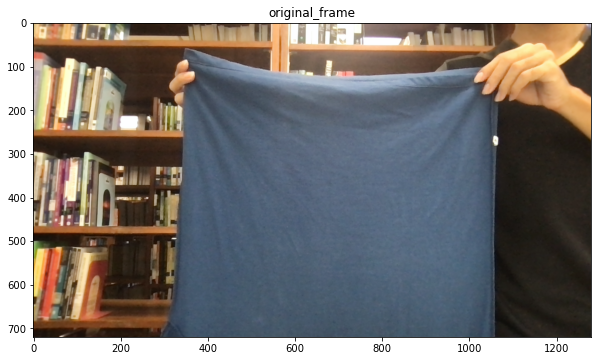

writing an image done!


In [14]:
cloak_img=cap_screen('cloak.jpg')

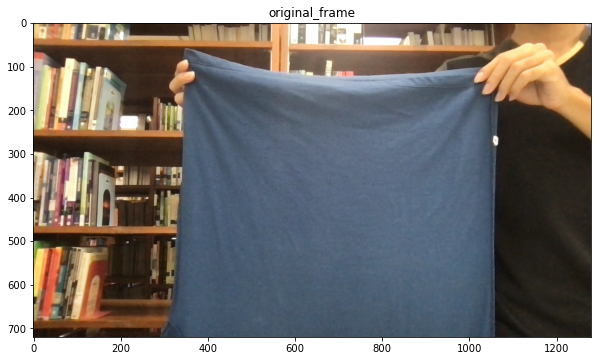

interactive(children=(IntSlider(value=199, description='Hmin', max=360), IntSlider(value=15, description='Smin…

In [4]:
# test on a static cap_screen image with interactive slider 

import math 

def plot_img(img,title):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(img)


def load_img(path):
    img = cv2.imread(path)
    plot_img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),'original_frame')
    return img 
            
            
def hsv_filter(Hmin,Smin,Vmin,Hmax,Smax,Vmax):
    hsv_frame = cv2.cvtColor(videoFrameBGR, cv2.COLOR_BGR2HSV)

    Hmin = Hmin//2.0
    Smin = math.floor(Smin*2.55)
    Vmin = math.floor(Vmin*2.55)

    Hmax = Hmax//2.0
    Smax = math.floor(Smax*2.55)
    Vmax = math.floor(Vmax*2.55)


    print( (Hmin,Smin,Vmin),(Hmax,Smax,Vmax))

    mask = cv2.inRange(hsv_frame,(Hmin,Smin,Vmin),(Hmax,Smax,Vmax))[:,:,np.newaxis]
    mask = np.repeat(mask,3,axis=2)
    plot_img(mask,'mask')
    


# videoFrameBGR = cap_screen()

videoFrameBGR = load_img('cloak.jpg')

interact(hsv_filter, 
         Hmin=widgets.IntSlider(min=0,max=360,step=1,value=199),
         Smin=widgets.IntSlider(min=0,max=100,step=1,value=15),
         Vmin=widgets.IntSlider(min=0,max=100,step=1,value=34),
         Hmax=widgets.IntSlider(min=0,max=360,step=1,value=231),
         Smax=widgets.IntSlider(min=0,max=100,step=1,value=51),
         Vmax=widgets.IntSlider(min=0,max=100,step=1,value=77));

0!
1!
2!
3!
Action!


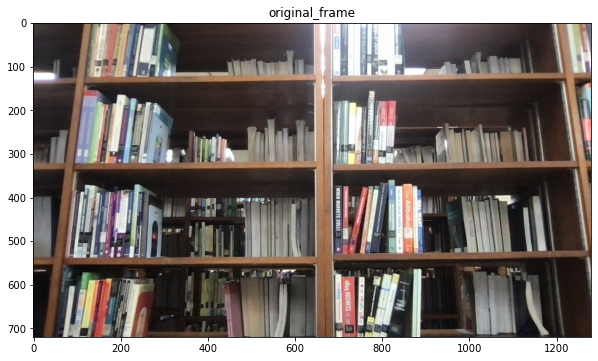

writing an image done!


In [8]:
bg_img = cap_screen('bg.jpg')

In [9]:

cameraNo = 0

def sliderCallback(x):
    pass

def plot_img(img,title,cmap='rgb'):
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(img)
    plt.show()


def draw_contours(inputImage,contours):
    img = np.array(inputImage)
    for rcbContourIdx in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        # Calculates the bounding rectangle of a contour
        x, y, w, h = cv2.boundingRect(contours[rcbContourIdx])
        cv2.drawContours(img, contours, rcbContourIdx, [255,0,0], 2)
        cv2.rectangle(img,(x,y),(x+w,y+h),[0,0,255],3)
    return img 

def fill_contour(InputImage,contour):
    img = np.zeros(InputImage.shape,dtype=np.uint8)
    cv2.fillPoly(img, pts =[contour], color=(255,255,255))
    return img


def find_bigest_countour(input_img,contours,area_threshold = 5000):
    biggest_contour_img = np.array(input_img)
    biggest_contour_mask = np.zeros(input_img.shape,dtype=np.uint8)
    if len(contours) == 0: return biggest_contour_img,None,biggest_contour_mask,(0,0,0,0)
    areas = [cv2.contourArea(a) for a in contours]
    sorted_areas = sorted(areas,reverse=True)
    if sorted_areas[0] <= area_threshold: return biggest_contour_img,None,biggest_contour_mask,(0,0,0,0)
    biggest_contour_idx = areas.index(sorted_areas[0])
    biggest_countor = contours[biggest_contour_idx]
    cv2.drawContours(biggest_contour_img, contours, biggest_contour_idx, [0,0,255], 2)
    x, y, w, h = cv2.boundingRect(contours[biggest_contour_idx])
    cv2.rectangle(biggest_contour_img,(x,y),(x+w,y+h),[0,0,255],3)
    cv2.drawContours(biggest_contour_mask, contours, biggest_contour_idx, [255,255,255], 2)
    return biggest_contour_img,biggest_contour_idx,biggest_contour_mask, (x, y, w, h )
    
def write_video(videos_frames,title):
    inputWidth, inputHeight = videos_frames[0].shape[1], videos_frames[0].shape[0]
    fname = f'{title}.mp4'
    outputStream = cv2.VideoWriter(fname,
                               cv2.VideoWriter_fourcc('x', '2', '6', '4'),
                               25, (inputWidth, inputHeight))
    for frame in videos_frames:
            # Write frame to outputStream
            outputStream.write(frame)
            # Encode image as jpg numpy array
            _, buffer = cv2.imencode(".jpg", frame)
            # Draw result
            IPython.display.display(IPython.display.Image(data=buffer))
            # Discard old output
            clear_output(wait=True)
    outputStream.release()
    
    print("write video file complete")
    
# Create a OpenCV Window
windowName = 'Color Segmentation'
cv2.namedWindow(windowName)
cv2.createTrackbar('Hmin',windowName,0,360,sliderCallback)
cv2.createTrackbar('Smin',windowName,0,100,sliderCallback)
cv2.createTrackbar('Vmin',windowName,0,100,sliderCallback)
cv2.createTrackbar('Hmax',windowName,0,360,sliderCallback)
cv2.createTrackbar('Smax',windowName,0,100,sliderCallback)
cv2.createTrackbar('Vmax',windowName,0,100,sliderCallback)


video_frames = []; cloak_detect_frames = []; clock_mask_frames = []; invis_frames = []
bg_img  = cv2.imread('bg.jpg')
inputStream = cv2.VideoCapture(cameraNo) 
try:
    while True:
        _, videoFrameBGR = inputStream.read()
        if videoFrameBGR is not None:
            
            video_frames.append(videoFrameBGR)
            hsv_frame = cv2.cvtColor(videoFrameBGR, cv2.COLOR_BGR2HSV)
            
            # parameter for face detection : I tune it myself
            Hmin = 199//2
            Smin = math.floor(15*2.55)
            Vmin = math.floor(34*2.55)
            
            Hmax = 231//2
            Smax =  math.floor(51*2.55)
            Vmax =  math.floor(77*2.55)
            
            
            mask = cv2.inRange(hsv_frame,(Hmin,Smin,Vmin),(Hmax,Smax,Vmax))[:,:,np.newaxis]
            mask = np.repeat(mask,3,axis=2)
            
    
            kernel = (5,5)
            cloak_mask = cv2.erode(mask, kernel, iterations = 2)
            cloak_mask = cv2.dilate(cloak_mask, kernel, iterations = 6)


            cloak = videoFrameBGR&cloak_mask

            cloak_mask_gray = cv2.cvtColor(cloak_mask, cv2.COLOR_BGR2GRAY)
            contours, _ = cv2.findContours(cloak_mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            contours_img = draw_contours(videoFrameBGR,contours)
            biggest_contour_img, biggest_contour_idx,biggest_contour_mask,rectangle = find_bigest_countour(videoFrameBGR,contours )
            
            
            
            cloak_detect_frames.append(biggest_contour_img)
            clock_mask_frames.append(biggest_contour_mask)
            
            x, y, w, h = rectangle
            filled_cloak = fill_contour(videoFrameBGR,np.moveaxis(np.array([[(x,y),(x+w,y),(x+w,y+h),(x,y+h)]]),[0,1,2],[-1,0,1])) if biggest_contour_idx  else biggest_contour_mask   
            filled_cloak = cv2.morphologyEx(filled_cloak, cv2.MORPH_CLOSE, kernel,iterations = 5)
            invis_img = np.array(videoFrameBGR)
            invis_img[y:y+h,x:x+w] = bg_img[y:y+h,x:x+w]   #origin is top left; x:verticle, y:horizontal
            invis_frames.append(invis_img)
            output = np.hstack((videoFrameBGR,contours_img,biggest_contour_img,biggest_contour_mask,filled_cloak,invis_img))
            
            cv2.imshow(windowName,output)
            if cv2.waitKey(1) == ord('q'):
                cv2.destroyAllWindows()
                break
        else:
            print("Cannot Open Webcam, hw problem?")
            break
except KeyboardInterrupt:
    
    print ("Stream stopped")
    inputStream.release()
    write_video(video_frames,'origin_cloak')
    write_video(cloak_detect_frames,'cloak_detection')
    write_video(invis_frames,'black_magic')
    cv2.destroyAllWindows()

write video file complete
